In [5]:
import os
import glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import wandb
from wandb.keras import WandbCallback

In [3]:
wandb.login()

wandb: Currently logged in as: aiffel (use `wandb login --relogin` to force relogin)


True

In [4]:
wandb.init(project='sia', entity='aiffel')

In [7]:
wandb.config.update({"image_size": 512, 
                     "learning_rate": 0.0001, 
                     "batch_size": 1, 
                     "epochs": 10,
                     "backbone": "efficientnetb7",
                     "class": "mixed",
                     "preprocess": "none"})

In [8]:
config = wandb.config

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
x_train_dir = './mixed/train/raw/'
y_train_dir = './mixed/train/label/'

x_valid_dir = './mixed/val/raw/'
y_valid_dir = './mixed/val/label/'

In [11]:
# helper function for data visualizationroads_new_label_val
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [12]:
masks_fps = glob.glob(y_train_dir + "*.png")

In [13]:
masks_fps[0]

'./mixed/train/label/BLD00709_PS3_K3A_NIA0277.png'

In [14]:
mask = cv2.imread(masks_fps[0], 0)

In [15]:
mask

array([[149, 149, 149, ...,   0,   0,  76],
       [149, 149, 149, ...,   0,  76,  76],
       [149, 149, 149, ...,  76,  76,  76],
       ...,
       [  0,   0,   0, ..., 149, 149, 149],
       [  0,   0,   0, ..., 149, 149, 149],
       [  0,   0,   0, ..., 149, 149, 149]], dtype=uint8)

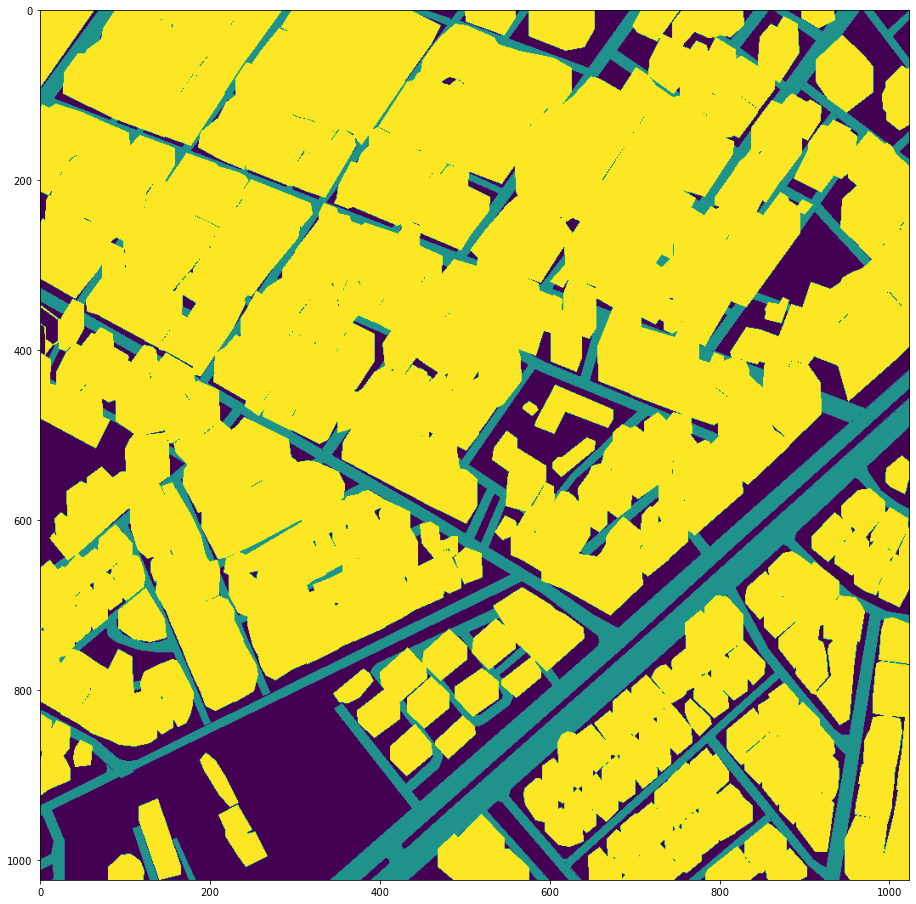

In [16]:
fig = plt.figure(figsize=(16, 16))
plt.imshow(mask)

In [17]:
CLASSES = ['building', 'road']

In [18]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = glob.glob(images_dir + "*.png")
        self.masks_fps = glob.glob(masks_dir + "*.png")
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = [149, 76]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [19]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return (batch[0], batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [20]:
import albumentations as A

In [21]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Resize(config.image_size, config.image_size)
    ]
    return A.Compose(_transform)

In [22]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

In [23]:
image, mask = dataset[0] # get some sample

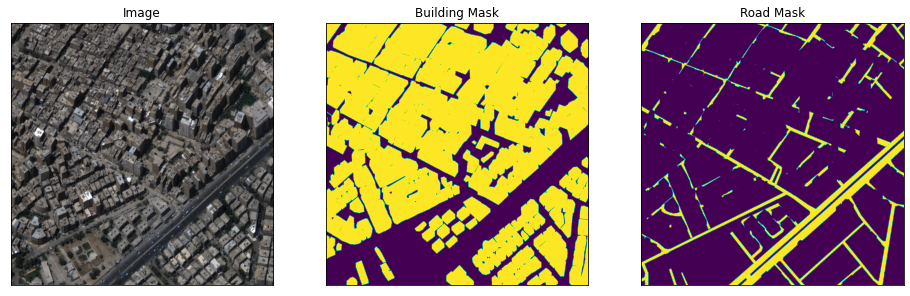

In [24]:
visualize(
    image=image, 
    building_mask=mask[..., 0].squeeze(),
    road_mask=mask[..., 1].squeeze(),
)

In [25]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [26]:
BACKBONE = config.backbone
BATCH_SIZE = config.batch_size
LR = config.learning_rate
EPOCHS = config.epochs

preprocess_input = sm.get_preprocessing(BACKBONE)

In [27]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [28]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [29]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, config.image_size, config.image_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, config.image_size, config.image_size, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
ckpt_dir = f'./models/{BACKBONE}/cp.ckpt'
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=ckpt_dir, save_weights_only=True, save_best_only=True, mode='min', verbose=1),
    keras.callbacks.ReduceLROnPlateau(),
    WandbCallback()
]

In [30]:
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [31]:
print(valid_dataloader[0][0].shape)
print(valid_dataloader[0][1].shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [32]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
324/324 [==============================] - ETA: 0s - loss: 0.5607 - iou_score: 0.3983 - f1-score: 0.5295
Epoch 00001: val_loss improved from inf to 0.46417, saving model to ./models/efficientnetb7/cp.ckpt
324/324 [==============================] - 125s 385ms/step - loss: 0.5607 - iou_score: 0.3983 - f1-score: 0.5295 - val_loss: 0.4642 - val_iou_score: 0.4996 - val_f1-score: 0.6322
Epoch 2/10
324/324 [==============================] - ETA: 0s - loss: 0.4205 - iou_score: 0.5350 - f1-score: 0.6660
Epoch 00002: val_loss improved from 0.46417 to 0.38916, saving model to ./models/efficientnetb7/cp.ckpt
324/324 [==============================] - 123s 381ms/step - loss: 0.4205 - iou_score: 0.5350 - f1-score: 0.6660 - val_loss: 0.3892 - val_iou_score: 0.5534 - val_f1-score: 0.6796
Epoch 3/10
324/324 [==============================] - ETA: 0s - loss: 0.3595 - iou_score: 0.5934 - f1-score: 0.7177
Epoch 00003: v

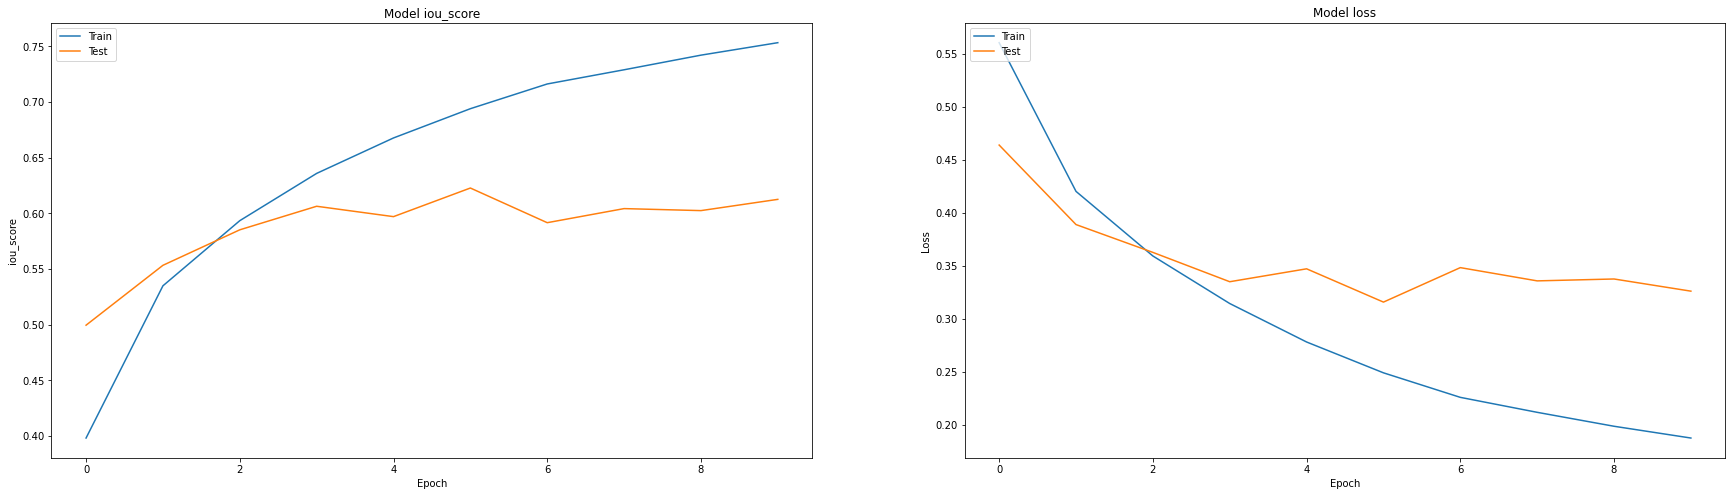

In [33]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 8))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [35]:
# load best weights
model.load_weights(ckpt_dir) 

In [36]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Loss: 0.31602
mean iou_score: 0.62274
mean f1-score: 0.74177


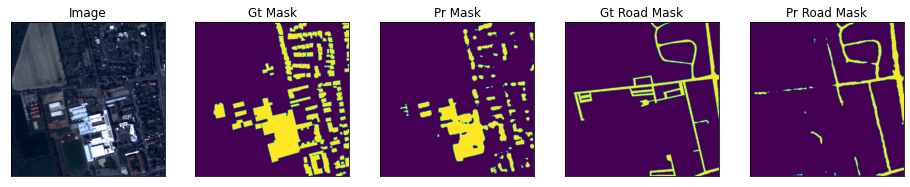

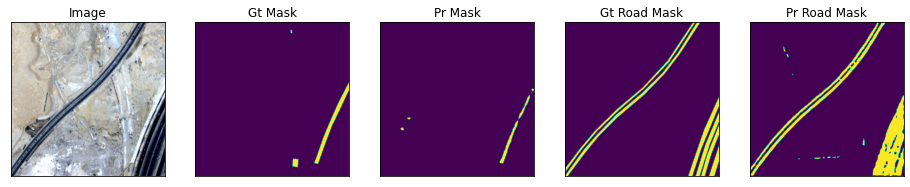

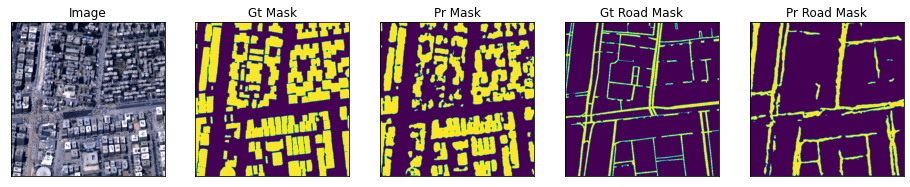

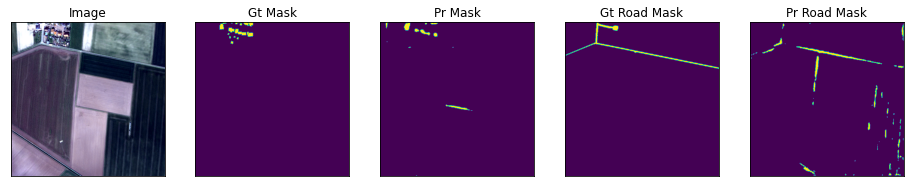

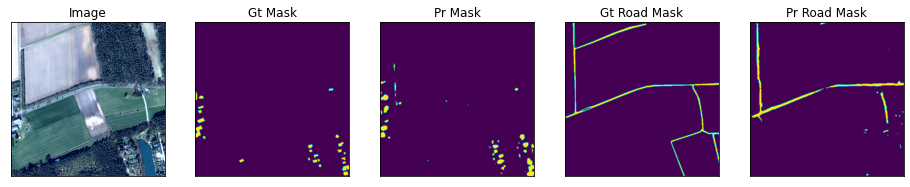

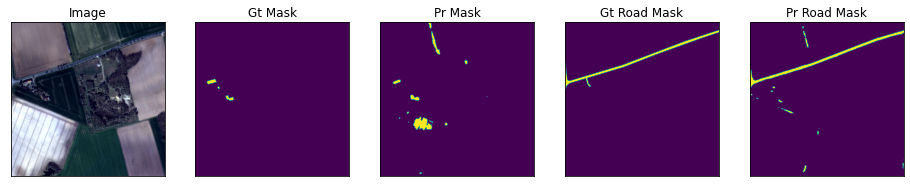

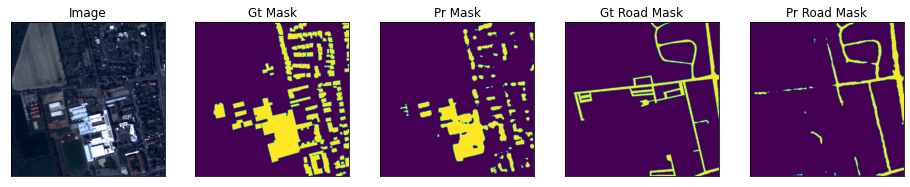

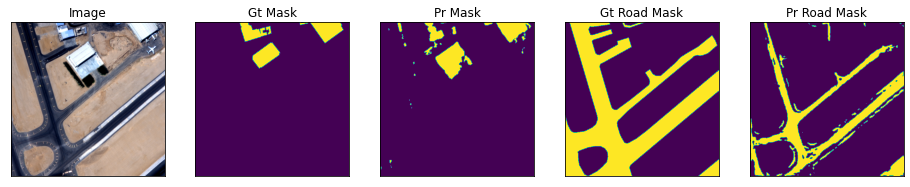

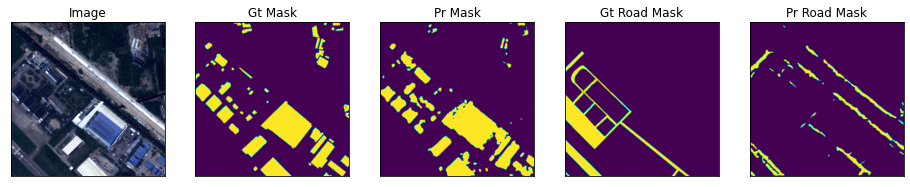

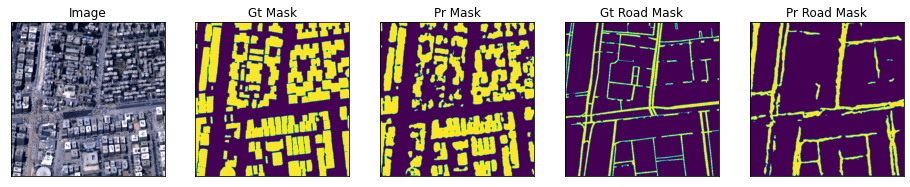

In [37]:
n = 10
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
        gt_road_mask=gt_mask[..., 1].squeeze(),
        pr_road_mask=pr_mask[..., 1].squeeze(),
    )

In [38]:
gt_mask.shape

(512, 512, 3)

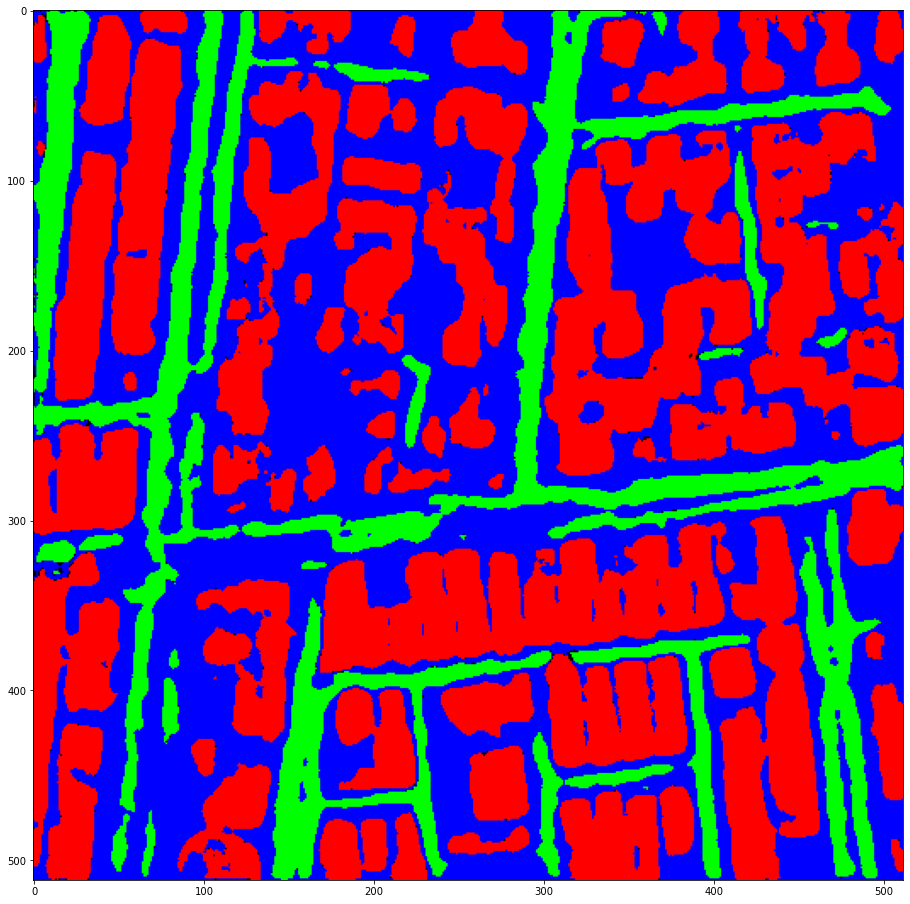

In [39]:
fig = plt.figure(figsize=(16, 16))
plt.imshow(pr_mask.squeeze())